From [https://gis.stackexchange.com/questions/372035/find-closest-point-to-shapefile-coastline-in-python](https://gis.stackexchange.com/questions/372035/find-closest-point-to-shapefile-coastline-in-python)

In [25]:
import sys
import geopandas as gpd
from shapely.geometry import Point, box
from random import uniform
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import shapely
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, plot_terrain
from utils import round_latlon_degree

In [20]:
path_to_data = '/home/dnash/comet_data/'
path_to_out = '../out/'
path_to_figs = '../figs/'

In [14]:
## use geopandas to import the shapefile

fp = path_to_data + 'downloads/continental_divide_shapefile/pw312bv3382.shp'
polys = gpd.read_file(fp, crs="epsg:4326") # have to manually set the projection

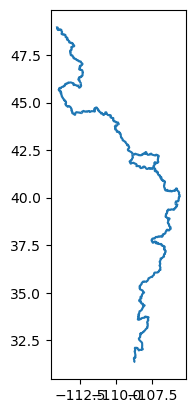

In [15]:
fig, ax = plt.subplots() # initiates a figure
polys.plot(ax=ax); # plots all lines

In [5]:


# pull all the points from the shapefile
lines = []
for icoast in range(len(polys)):
    coastline = polys.iloc[icoast].geometry #< This is a linestring

    if type(coastline) is shapely.geometry.linestring.LineString:
        coastline = [list(i) for i in coastline.coords]
    elif type(coastline) is shapely.geometry.multilinestring.MultiLineString:
        dummy = []
        for line in coastline:
            dummy.extend([list(i) for i in line.coords])
        coastline = dummy
        
    lines.append(coastline)
    
# for each line, create a list of lats and lons
lat = []
lon = []
for i, line in enumerate(lines):
    for j, pt in enumerate(line):
        lat.append(pt[1])
        lon.append(pt[0])

## put those points into a pandas dataframe
d = {'latitude': lat, 'longitude': lon}
df = pd.DataFrame(data=d)
df

latitude   longitude
0     49.000412 -114.074654
1     48.991344 -114.077240
2     48.981037 -114.070847
3     48.968395 -114.063889
4     48.957684 -114.060257
...         ...         ...
4367  31.382887 -108.746521
4368  31.376032 -108.743317
4369  31.366453 -108.746033
4370  31.357336 -108.751419
4371  31.333286 -108.776428

[4372 rows x 2 columns]

In [8]:
## round the lats lons to 0.5 degrees and remove duplicates
new_df = round_latlon_degree(df, 0.5)
new_df = new_df.drop(['latitude', 'longitude'], axis=1) 
new_df = new_df.drop_duplicates(subset=None, keep="first", inplace=False)
new_df = new_df.drop_duplicates(subset='lat-round', keep="first", inplace=False)
new_df

lon-round  lat-round
0        -114.0       49.0
63       -113.5       48.5
117      -113.0       48.0
167      -113.0       47.5
212      -112.5       47.0
307      -112.5       46.5
428      -112.5       46.0
593      -114.0       45.5
681      -113.5       45.0
808      -113.0       44.5
1374     -110.5       44.0
1487     -110.0       43.5
1593     -109.5       43.0
1689     -109.0       42.5
1803     -108.5       42.0
2013     -107.5       41.5
2413     -107.0       41.0
2530     -106.5       40.5
2732     -105.5       40.0
2821     -106.0       39.5
2979     -106.5       39.0
3086     -106.5       38.5
3199     -106.5       38.0
3377     -107.5       37.5
3580     -106.5       37.0
3651     -107.0       36.5
3688     -107.0       36.0
3753     -108.0       35.5
3815     -108.5       35.0
3866     -108.5       34.5
3930     -108.0       34.0
3985     -108.5       33.5
4112     -108.0       33.0
4182     -108.5       32.5
4224     -108.0       32.0
4323     -108.5       31.5

In [22]:
## write to csv
new_df.to_csv(path_to_out + 'continental_divide_points.csv')

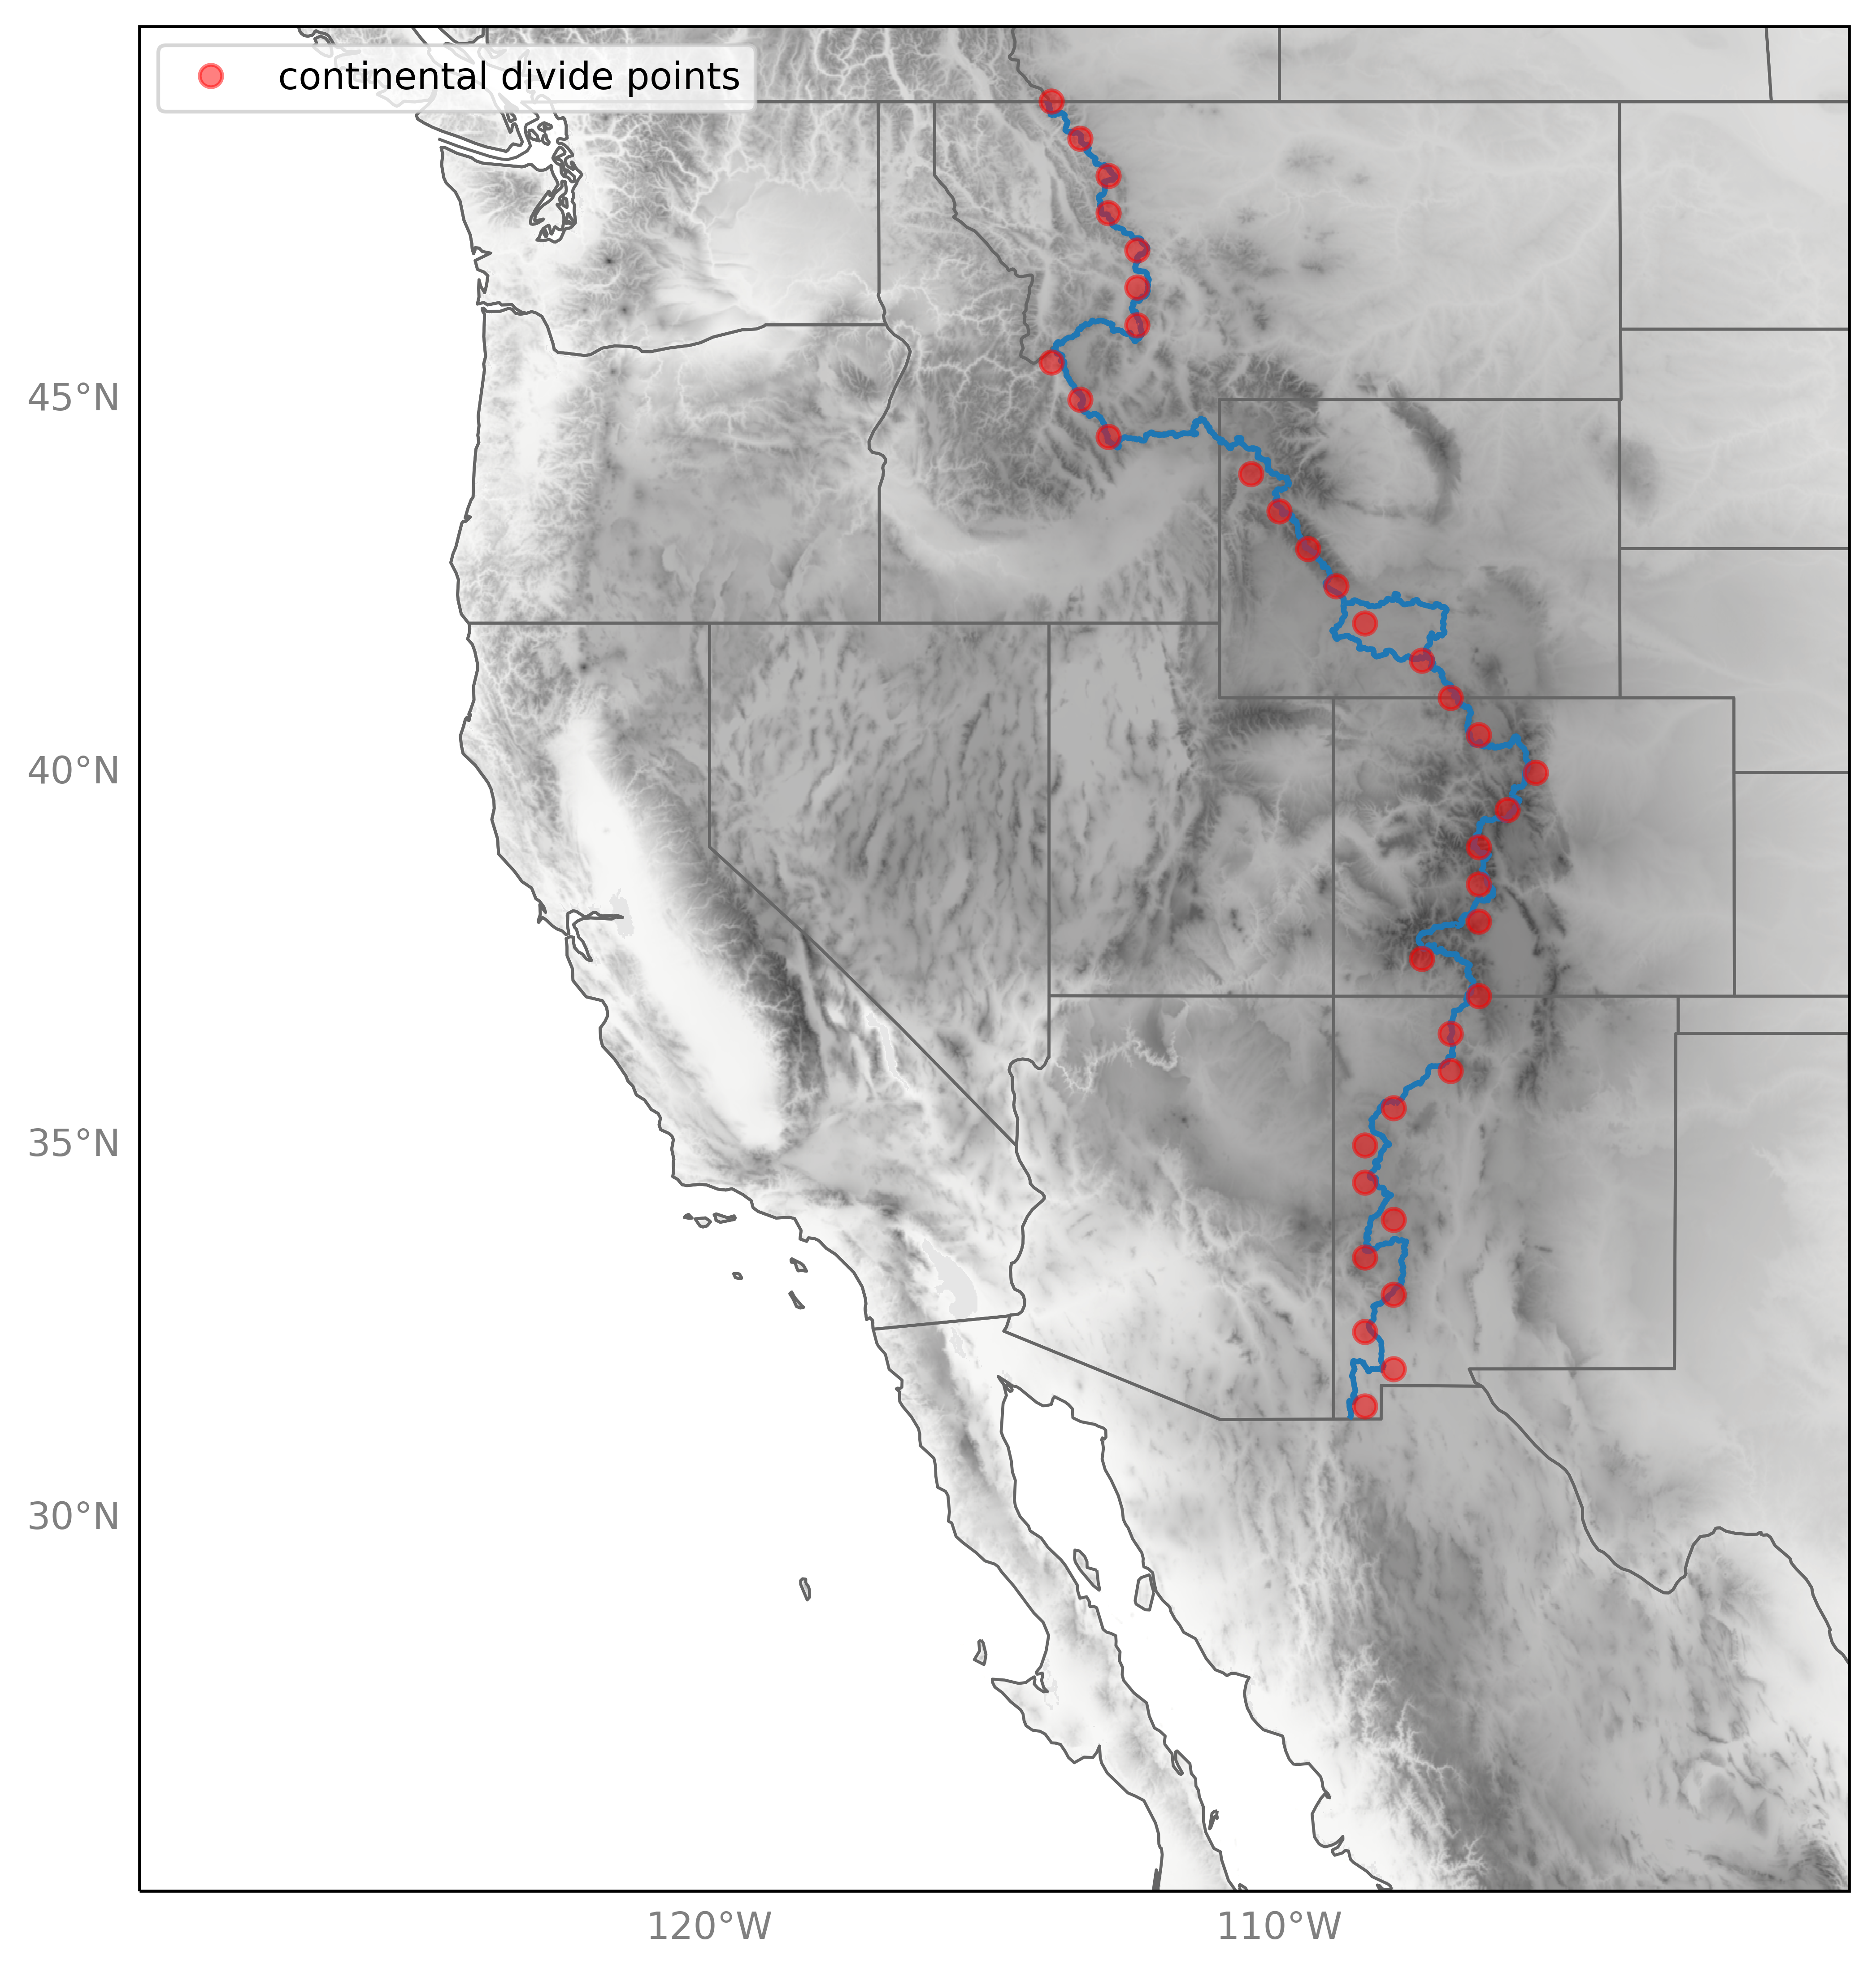

In [29]:
ext = [-130., -100., 25., 50.] # extent of interior west
fmt = 'png'

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

fig = plt.figure(figsize=(9.0 ,9.0))
fig.dpi = 600
fname = path_to_figs + 'continental_divide_points_AR_scale'

ax = plt.axes(projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=True, right_lats=False)
ax.set_extent(ext, datacrs)

polys.plot(ax=ax); # plots all lines
ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

# need this to fix annotate transform
transform = datacrs._as_mpl_transform(ax)

## Add different points
colors = ['ro']
lbl_lst = ['continental divide points']
df_lst = [new_df]
for i, df in enumerate(df_lst):
    x = df['lon-round'].values
    y = df['lat-round'].values
    ax.plot(x, y, colors[i], markersize=6, transform=datacrs, alpha=0.5, label=lbl_lst[i])
    
leg = ax.legend(loc='upper left', ncol=1)

## Add elevation contours
ax = plot_terrain(ax, ext)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()